# Eigenvalue problem of Cauchy-Euler equation

In [1]:
import sympy as sym
import numpy as np
from scipy import special as specfun

import matplotlib.pyplot as plt
# %matplotlib notebook

---
## Problem setup

Setup operators. The eigenvalue problem is:

In [3]:
x = sym.Symbol("x")
ev = sym.Symbol(r"\lambda")
l_deg = sym.Symbol('l', integer=True)
r_deg = sym.Symbol('n', integer=True)
y = sym.Function("y")(x)

def Op_Cauchy_Euler(f, l):
    return sym.diff(x**2*sym.diff(f, x), x) - l*(l + 1)*f

op_expr = Op_Cauchy_Euler(y, l_deg)
# op_expr = sym.diff(y, (x, 2))
sym.Eq(ev*y, op_expr)

Eq(\lambda*y(x), -l*(l + 1)*y(x) + x**2*Derivative(y(x), (x, 2)) + 2*x*Derivative(y(x), x))

Setup spectral basis and test functions

In [4]:
# def JonesWorland(n, l):
#     return x**l*sym.jacobi(n, -sym.S.Half, l - sym.S.Half, 2*x**2 - 1)
# y_spec = JonesWorland(r_deg, l_deg)
# op_expr_spec = op_expr.subs({y: y_jw})

y_spec = sym.chebyshevt(r_deg, 2*x - 1)
op_expr_spec = op_expr.subs({y: y_spec})

---
## Matrix assembly

Matrix construction utilities

In [6]:
def compute_matrices(test_f, spec_expr, quad_pts, quad_wts, N):
    N_mesh, quad_mesh = np.meshgrid(np.arange(N), quad_pts, indexing='ij')
    eval_test_f = sym.lambdify([r_deg, x], test_f, modules=["numpy", "scipy"])
    mat_test_f = eval_test_f(N_mesh, quad_mesh)
    eval_spec_expr = sym.lambdify([r_deg, x], spec_expr, modules=["numpy", "scipy"])
    mat_spec_expr = eval_spec_expr(N_mesh, quad_mesh)
    return (mat_test_f*quad_wts) @ mat_spec_expr.T

def tau_line_zero(spec_basis, N):
    eval_basis = sym.lambdify([r_deg, x], spec_basis, modules=["numpy", "scipy"])
    return eval_basis(np.arange(N), 0.)

def tau_line_toroidal_void_bc(spec_basis, N):
    eval_basis = sym.lambdify([r_deg, x], spec_basis, modules=["numpy", "scipy"])
    return eval_basis(np.arange(N), 1)

def tau_line_poloidal_void_bc(spec_basis, N, l):
    bc_expr = sym.diff(spec_basis, x) + (l + 1)/x*spec_basis
    eval_basis = sym.lambdify([r_deg, x], bc_expr, modules=["numpy", "scipy"])
    return eval_basis(np.arange(N), 1)

Calculate the matrices

In [26]:
l_val = sym.Integer(2)
Ntrunc = 150
xi_quad, w_quad = specfun.roots_chebyt(4*Ntrunc + 1)
x_quad = (1 + xi_quad)/2

K_mat = compute_matrices(y_spec, op_expr_spec.subs({l_deg: l_val}).doit(), x_quad, w_quad, Ntrunc)
M_mat = compute_matrices(y_spec, y_spec, x_quad, w_quad, Ntrunc)
M_mat[-1, :] = tau_line_poloidal_void_bc(y_spec, Ntrunc, l_val)
K_mat[-1, :] = 0.
# M_mat[-1, :] = tau_line_toroidal_void_bc(y_spec, Ntrunc)
# K_mat[-1, :] = 0.
# M_mat[-2, :] = tau_line_zero(y_spec, Ntrunc)
# K_mat[-2, :] = 0.

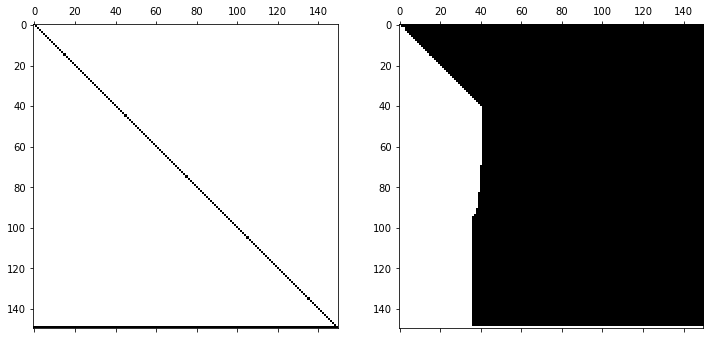

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax = axes[0]
ax.spy(M_mat, precision=1e-7)
ax = axes[1]
ax.spy(K_mat, precision=1e-7)

plt.show()
# plt.ion()

---
## Eigenproblem solution

Compute eigenvalues

In [28]:
from scipy import linalg

W, V = linalg.eig(K_mat, b=M_mat)
sort_idx = np.argsort(np.abs(W))
W = W[sort_idx]
V = V[:, sort_idx]

In [29]:
W

array([-1.11444506e-10+0.j, -6.26483061e+00+0.j, -6.39003773e+00+0.j,
       -6.66724288e+00+0.j, -7.12858629e+00+0.j, -7.80595530e+00+0.j,
       -8.72830571e+00+0.j, -9.92767201e+00+0.j, -1.14318947e+01+0.j,
       -1.32748181e+01+0.j, -1.54833419e+01+0.j, -1.80933809e+01+0.j,
       -2.11309103e+01+0.j, -2.46341879e+01+0.j, -2.86285146e+01+0.j,
       -3.31548624e+01+0.j, -3.82381954e+01+0.j, -4.39225822e+01+0.j,
       -5.02329748e+01+0.j, -5.72169041e+01+0.j, -6.48996006e+01+0.j,
       -7.33324121e+01+0.j, -8.25411127e+01+0.j, -9.25812252e+01+0.j,
       -1.03479320e+02+0.j, -1.15295469e+02+0.j, -1.28057291e+02+0.j,
       -1.41829807e+02+0.j, -1.56641946e+02+0.j, -1.72564112e+02+0.j,
       -1.89626823e+02+0.j, -2.07906341e+02+0.j, -2.27435078e+02+0.j,
       -2.48295678e+02+0.j, -2.70522782e+02+0.j, -2.94205998e+02+0.j,
       -3.19382569e+02+0.j, -3.46149715e+02+0.j, -3.74547702e+02+0.j,
       -4.04682086e+02+0.j, -4.36596626e+02+0.j, -4.70406029e+02+0.j,
       -5.06158086e+

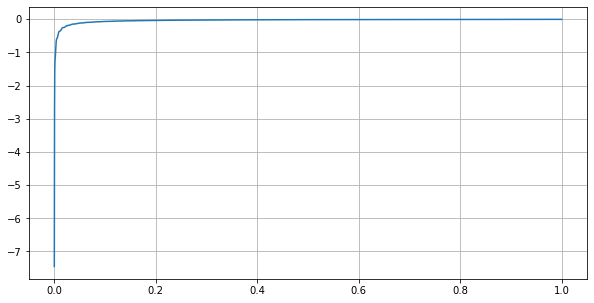

In [19]:
mode_idx = 1
x_view = x_quad

y_func = sym.lambdify([x, r_deg], y_spec, modules=["numpy", "scipy"])
X_mesh, N_mesh = np.meshgrid(x_view, np.arange(Ntrunc), indexing='ij')
y_view = np.sum(y_func(X_mesh, N_mesh)*V[:, mode_idx], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_view, y_view)
ax.grid(which="both")

Output

In [30]:
import h5py

fname = "../out/tmp/Cauchy-Euler_l2_poloidal_BC__N150.h5"
with h5py.File(fname, 'x') as fwrite:
    fwrite.attrs["Basis"] = "Chebyshev"
    fwrite.create_dataset("W", data=W)
    fwrite.create_dataset("V", data=V)

Solution visualization

In [31]:
f_list = [
    "../out/tmp/Cauchy-Euler_l2_poloidal_BC__N50.h5", 
    "../out/tmp/Cauchy-Euler_l2_poloidal_BC__N100.h5", 
    "../out/tmp/Cauchy-Euler_l2_poloidal_BC__N150.h5"
]
labels = [50, 100, 150]

eval_list = list()
evec_list = list()

for fname in f_list:
    with h5py.File(fname, 'r') as fread:
        eval_list.append(fread["W"][()])
        evec_list.append(fread["V"][()])

In [33]:
import pandas as pd

N_keep = 20

df = pd.DataFrame(data={labels[i]: eval_list[i][:N_keep] for i in range(len(labels))})
df

,50,100,150
0,5.582278e-13+0.000000e+00j,6.479411e-13+0.000000e+00j,-1.114445e-10+0.000000e+00j
1,-6.271764e+00+0.000000e+00j,-6.266928e+00+0.000000e+00j,-6.264831e+00+0.000000e+00j
2,-6.462003e+00+0.000000e+00j,-6.411311e+00+0.000000e+00j,-6.390038e+00+0.000000e+00j
3,-6.907999e+00+0.000000e+00j,-6.736444e+00+0.000000e+00j,-6.667243e+00+0.000000e+00j
4,-7.688030e+00+0.000000e+00j,-7.285600e+00+0.000000e+00j,-7.128586e+00+0.000000e+00j
5,-8.891743e+00+0.000000e+00j,-8.103409e+00+0.000000e+00j,-7.805955e+00+0.000000e+00j
6,-1.060429e+01+0.000000e+00j,-9.230819e+00+0.000000e+00j,-8.728306e+00+0.000000e+00j
7,-1.293907e+01+0.000000e+00j,-1.071582e+01+0.000000e+00j,-9.927672e+00+0.000000e+00j
8,-1.599349e+01+0.000000e+00j,-1.259952e+01+0.000000e+00j,-1.143189e+01+0.000000e+00j
9,-1.991228e+01+0.000000e+00j,-1.493539e+01+0.000000e+00j,-1.327482e+01+0.000000e+00j


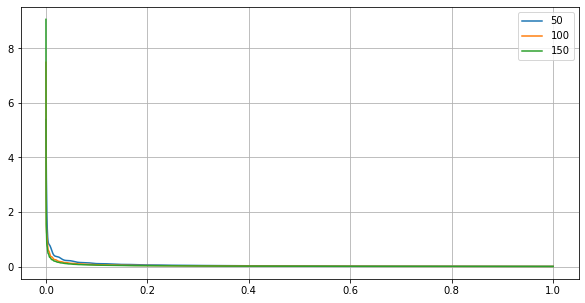

In [37]:
mode_idx = [1, 1, 1]
x_view = x_quad
fig, ax = plt.subplots(figsize=(10, 5))

y_func = sym.lambdify([x, r_deg], y_spec, modules=["numpy", "scipy"])

for i in range(len(labels)):
    v_tmp = evec_list[i][:, mode_idx[i]]
    X_mesh, N_mesh = np.meshgrid(x_view, np.arange(v_tmp.size), indexing='ij')
    y_view = np.sum(y_func(X_mesh, N_mesh)*v_tmp, axis=1)
    if y_view[0] < 0:
        y_view = -y_view
    
    ax.plot(x_view, y_view, label=labels[i])
    
ax.grid(which="both")
ax.legend()
plt.show()